In [1]:
import os, sys
import os.path
import pickle
import numpy as np
import pandas as pd
import itertools as it
sys.path.append('./GDMaps_PCE/')

from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA import *

from UQpy.distributions import Normal, Uniform, JointIndependent

from SPCE_optuna import  *

import matplotlib.pyplot as plt
import matplotlib as mpl
from mycolorpy import colorlist as mcp

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.1
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [2]:
def calculate_first_order_indices(pce_coefficients,
                                  dist_object_x,
                                  multi_index_set,
                                  sigma,
                                  with_Z = False): 
    """
    PCE estimates for the first order Sobol indices.
    """
    outputs_number = np.shape(pce_coefficients)[1]

    variance = np.sum(pce_coefficients[1:] ** 2, axis=0)
#     print(variance)
    
    if with_Z:
        inputs_number = len(dist_object_x.marginals) + 1
    else:
        inputs_number = len(dist_object_x.marginals)
        
    multi_index_set = multi_index_set

    first_order_indices = np.zeros([inputs_number, outputs_number])
    # take all multi-indices except 0-index
    idx_no_0 = np.delete(multi_index_set, 0, axis=0)
    for nn in range(inputs_number):
        # remove nn-th column
        idx_no_0_nn = np.delete(idx_no_0, nn, axis=1)
        # we want the rows with all indices (except nn) equal to zero
        sum_idx_rows = np.sum(idx_no_0_nn, axis=1)
        zero_rows = np.asarray(np.where(sum_idx_rows == 0)).flatten() + 1
        variance_contribution = np.sum(pce_coefficients[zero_rows, :] ** 2, axis=0)
#         print(variance_contribution)
        first_order_indices[nn, :] = variance_contribution / (variance + sigma**2)
#         first_order_indices[nn, :] = variance_contribution / (variance)
    first_order_indices = first_order_indices
    return first_order_indices


def calculate_total_order_indices(pce_coefficients,
                                  dist_object_x,
                                  multi_index_set,
                                  sigma,
                                  with_Z = False):
    """
    PCE estimates for the total order Sobol indices.
    """

    outputs_number = np.shape(pce_coefficients)[1]

    variance = np.sum(pce_coefficients[1:] ** 2, axis=0)
    if with_Z:
        inputs_number = len(dist_object_x.marginals) + 1
    else:
        inputs_number = len(dist_object_x.marginals)
        
    multi_index_set = multi_index_set

    total_order_indices = np.zeros([inputs_number, outputs_number])
    for nn in range(inputs_number):
        # we want all multi-indices where the nn-th index is NOT zero
        idx_column_nn = np.array(multi_index_set)[:, nn]
        nn_rows = np.asarray(np.where(idx_column_nn != 0)).flatten()
        variance_contribution = np.sum(pce_coefficients[nn_rows, :] ** 2, axis=0)
#         print(variance_contribution)
        total_order_indices[nn, :] = variance_contribution / (variance + sigma**2)
#         total_order_indices[nn, :] = variance_contribution / (variance)
    total_order_indices = total_order_indices
    return total_order_indices

In [121]:
def plot_SI_histograms_ns(SPCE_res):
    
    D     = SPCE_res['x1']
    p     = SPCE_res['x2']
    q     = SPCE_res['x3']
    A     = SPCE_res['x4']
    c_hat = SPCE_res['x5']
    sigma_hat = SPCE_res['x6']
    cv_score  = SPCE_res['x7']

    SI_with_Z = calculate_first_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                       dist_object_x = joint_x,
                                       multi_index_set = A,
                                       sigma = sigma_hat,
                                       with_Z = True)

    # print("\n First-order indices \n", SI_with_Z)


    STI_with_Z = calculate_total_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                        dist_object_x = joint_x,
                                        multi_index_set = A,
                                        sigma = sigma_hat,
                                        with_Z = True)

    # print("\n Total-order indices \n", STI_with_Z)

#     SI = calculate_first_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
#                                        dist_object_x = joint_x,
#                                        multi_index_set = A,
#                                        sigma = sigma_hat*np.var(theta_i, ddof=1))

#     # print("\n First-order indices \n", SI)


#     STI = calculate_total_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
#                                         dist_object_x = joint_x,
#                                         multi_index_set = A,
#                                         sigma = sigma_hat*np.var(theta_i, ddof=1))

    # print("\n Total-order indices \n", STI)

    param_names = [r"$COST$", r"$\beta$", r"$\ell$"]
    bar_colors = [u'#1f77b4', u'#2ca02c', u'#d62728']

    param_names_with_Z = [r"$COST$", r"$\beta$", r"$\ell$", r"$Z$"]
    bar_colors_with_Z = [u'#1f77b4', u'#2ca02c', u'#d62728', "gray"]


#     fig, axs = plt.subplots(2, 2, figsize=(10,10))

#     axs[0, 0].bar(param_names, SI.reshape(3), color=bar_colors)
#     axs[0, 0].set_ylabel('First-order SI')

#     axs[0, 1].bar(param_names, STI.reshape(3), color=bar_colors)
#     axs[0, 1].set_ylabel('Total-order SI')

#     axs[1, 0].bar(param_names_with_Z, SI_with_Z.reshape(4), color=bar_colors_with_Z)
#     axs[1, 0].set_ylabel('First-order SI')

#     axs[1, 1].bar(param_names_with_Z, STI_with_Z.reshape(4), color=bar_colors_with_Z)
#     axs[1, 1].set_ylabel('Total-order SI')
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

#     axs[0, 0].bar(param_names, SI.reshape(3), color=bar_colors)
#     axs[0, 0].set_ylabel('First-order SI')

#     axs[0, 1].bar(param_names, STI.reshape(3), color=bar_colors)
#     axs[0, 1].set_ylabel('Total-order SI')

    axs[0].bar(param_names_with_Z, SI_with_Z.reshape(4), color=bar_colors_with_Z)
    axs[0].set_ylabel('First-order SI')

    axs[1].bar(param_names_with_Z, STI_with_Z.reshape(4), color=bar_colors_with_Z)
    axs[1].set_ylabel('Total-order SI')


    plt.tight_layout()

    plt.show()

In [123]:
def plot_SI_histograms(SPCE_res, theta_i):
    
    D     = SPCE_res['x1']
    p     = SPCE_res['x2']
    q     = SPCE_res['x3']
    A     = SPCE_res['x4']
    c_hat = SPCE_res['x5']
    sigma_hat = SPCE_res['x6']
    cv_score  = SPCE_res['x7']

    SI_with_Z = calculate_first_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                       dist_object_x = joint_x,
                                       multi_index_set = A,
                                       sigma = sigma_hat*np.var(theta_i, ddof=1),
                                       with_Z = True)

    # print("\n First-order indices \n", SI_with_Z)


    STI_with_Z = calculate_total_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                        dist_object_x = joint_x,
                                        multi_index_set = A,
                                        sigma = sigma_hat*np.var(theta_i, ddof=1),
                                        with_Z = True)

    # print("\n Total-order indices \n", STI_with_Z)

    SI = calculate_first_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                       dist_object_x = joint_x,
                                       multi_index_set = A,
                                       sigma = sigma_hat*np.var(theta_i, ddof=1))

    # print("\n First-order indices \n", SI)


    STI = calculate_total_order_indices(pce_coefficients = c_hat.reshape(-1, 1),
                                        dist_object_x = joint_x,
                                        multi_index_set = A,
                                        sigma = sigma_hat*np.var(theta_i, ddof=1))

    # print("\n Total-order indices \n", STI)

    param_names = [r"$COST$", r"$\beta$", r"$\ell$"]
    bar_colors = [u'#1f77b4', u'#2ca02c', u'#d62728']

    param_names_with_Z = [r"$COST$", r"$\beta$", r"$\ell$", r"$Z$"]
    bar_colors_with_Z = [u'#1f77b4', u'#2ca02c', u'#d62728', "gray"]


#     fig, axs = plt.subplots(2, 2, figsize=(10,10))

#     axs[0, 0].bar(param_names, SI.reshape(3), color=bar_colors)
#     axs[0, 0].set_ylabel('First-order SI')

#     axs[0, 1].bar(param_names, STI.reshape(3), color=bar_colors)
#     axs[0, 1].set_ylabel('Total-order SI')

#     axs[1, 0].bar(param_names_with_Z, SI_with_Z.reshape(4), color=bar_colors_with_Z)
#     axs[1, 0].set_ylabel('First-order SI')

#     axs[1, 1].bar(param_names_with_Z, STI_with_Z.reshape(4), color=bar_colors_with_Z)
#     axs[1, 1].set_ylabel('Total-order SI')
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

#     axs[0, 0].bar(param_names, SI.reshape(3), color=bar_colors)
#     axs[0, 0].set_ylabel('First-order SI')

#     axs[0, 1].bar(param_names, STI.reshape(3), color=bar_colors)
#     axs[0, 1].set_ylabel('Total-order SI')

    axs[0].bar(param_names_with_Z, SI_with_Z.reshape(4), color=bar_colors_with_Z)
    axs[0].set_ylabel('First-order SI')

    axs[1].bar(param_names_with_Z, STI_with_Z.reshape(4), color=bar_colors_with_Z)
    axs[1].set_ylabel('Total-order SI')


    plt.tight_layout()

    plt.show()

In [3]:
num_samples = 1024*5

In [4]:
def plot_dm_parsim_coord(coord, g):
    
    comb1 = list(it.combinations(list(coord), 2))
    comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

    # Plot first three plots
    if coord.shape[0] > 2:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
        
        for i in range(len(comb1)):
            ax[i].scatter(g[:, comb2[i][0]], g[:, comb2[i][1]], c=g[:, comb2[i][0]], 
                          cmap='viridis', s=30, edgecolors='k', linewidth=0.2)
            ax[i].set_xlabel(r'$\theta_{{{}}}$'.format(comb1[i][0]))
            ax[i].set_ylabel(r'$\theta_{{{}}}$'.format(comb1[i][1]))
            ax[i].grid('True')
            ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        plt.show()
        

In [14]:
# input parameters

with open('input_data/3_param_saltelli.pickle', 'rb') as f:
    saltelli_3_param = pickle.load(f)
      
pdf1 = Uniform(loc=0.01, scale=1.99) 
pdf2 = Uniform(loc=0.70, scale=0.10)  
pdf3 = Uniform(loc=0.30, scale=0.15)

margs = [pdf1, pdf2, pdf3]
joint_x = JointIndependent(marginals=margs)

x = saltelli_3_param


# Macro level

p=4

In [85]:
result_parsim = np.load(f'data/GSA_results/GDMaps/PT_macro_parsim_onerun_p_4.npz', 
                     allow_pickle=True)

g = result_parsim["x4"]


result_nonparsim = np.load(f'data/GSA_results/GDMaps/PT_macro_nonparsim_onerun_p_4.npz', 
                               allow_pickle=True)

macro_g_nonparsim = result_nonparsim["x4"]

macro_theta_1 = macro_g_nonparsim[:, 0].reshape(num_samples, 1)
macro_theta_2 = macro_g_nonparsim[:, 1].reshape(num_samples, 1)
macro_theta_3 = macro_g_nonparsim[:, 2].reshape(num_samples, 1)

Non-parsimonious rescaled


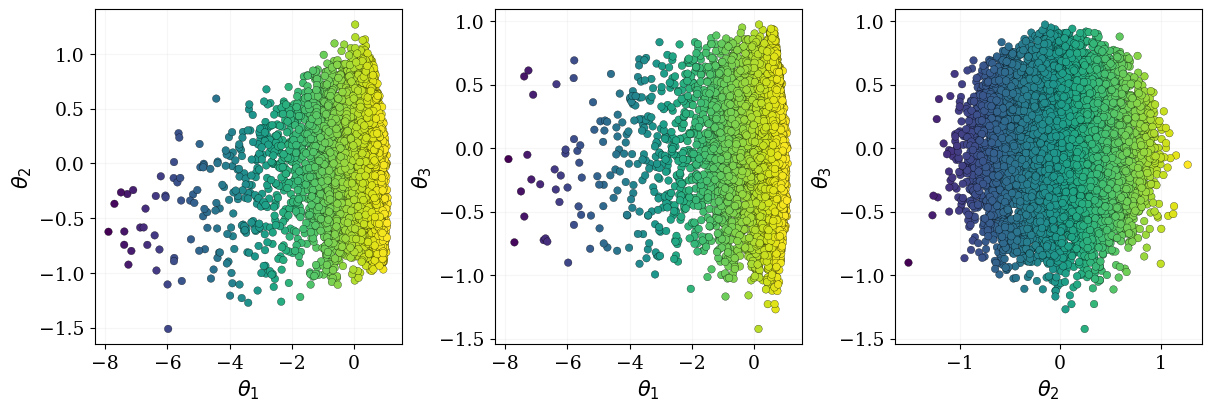

Non-parsimonious


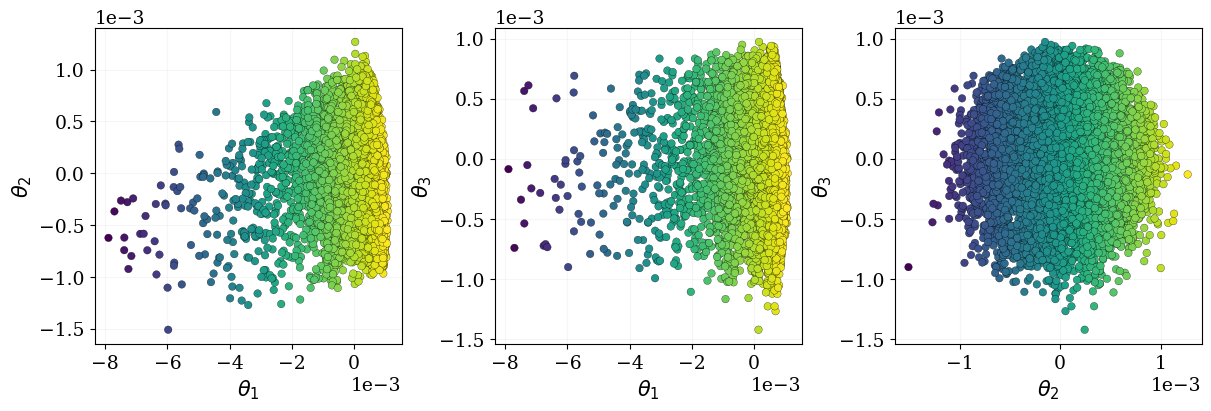

Parsimonious


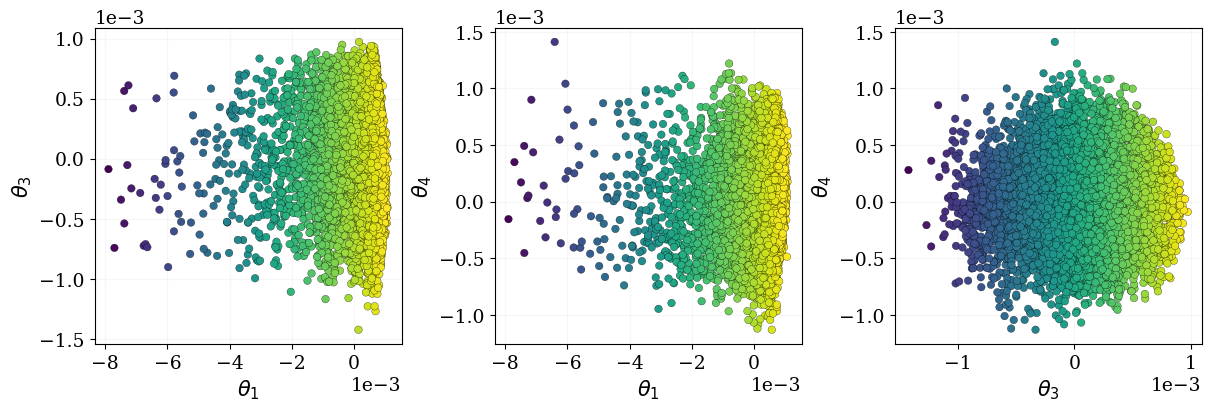

In [65]:
print("Non-parsimonious rescaled")
plot_dm_parsim_coord(coord=np.array([1,2,3]), g=macro_g_nonparsim/1.0e-03)

print("Non-parsimonious")
plot_dm_parsim_coord(coord=np.array([1,2,3]), g=macro_g_nonparsim)

print("Parsimonious")
plot_dm_parsim_coord(coord[0], g[0])

# Macro level: 

1. standardised theta
2. scaling the range for sigma with variance of theta

In [86]:
st_g_nonparsim = g_nonparsim/np.std(g_nonparsim, axis=0)

st_theta_1 = st_g_nonparsim[:, 0].reshape(num_samples, 1)
st_theta_2 = st_g_nonparsim[:, 1].reshape(num_samples, 1)
st_theta_3 = st_g_nonparsim[:, 2].reshape(num_samples, 1)

In [ ]:
# example how run

# PT_3_param_SPCE_st_theta_1_st = StochasticPCE(X = x, 
#                                               y = st_theta_1, 
#                                               dist_obj = joint_x,
#                                               D = ["Uniform", "Normal"], 
#                                               p_values = [3, 4, 5],
#                                               q_values = [0.5, 0.75, 1],
#                                               scale_e_LOO = 1,
#                                               sim_name = "PT_3_param_st_theta_1_U_N_p3_p5").fit_adaptively()

## Theta1 standardised

Normal:

`PT_3_param_st_theta_1_only_N_p3_p5`


Overall best is Normal, p=4, q=0.75


## Theta2 standardised

iPad

`PT_3_param_st_theta_2_only_N_p3_p5`

Normal
- p=3, q=0.5: -2395.7518070977053
- p=3, q=0.75: -2399.2927992857067
- p=3, q=1: did not run


- p=4, q=0.5: -2397.404926451926
- p=4, q=0.75: -2377.8776446136903


`PT_3_param_st_theta_2_only_N_p_4_q_1`
- p=4, q=1: -2378.35928513

`PT_3_param_st_theta_2_only_N_p5_q05_075`
- p=5, q=0.5: -2396.5150980565504

`PT_3_param_st_theta_2_only_N_p5_q075`
- **p=5, q=0.75: -2364.591446076596**

`PT_3_param_st_theta_2_only_N_p_5_q_1`
- p=5, q=1: -2418.26958675

Overall best is Normal, p=5, q=0.75

## Theta3 standardised

Normal:

`PT_3_param_st_theta_3_only_N_p3_p5`

- p=3, q=0.5: -2380.1374604094635
- *p=3, q=0.75: -2379.2413062080377*
- p=3, q=1: -2380.1903579352092


- *p=4, q=0.5: -2368.4279935985724*
- p=4, q=0.75: -2369.068334938068
- p=4, q=1: did not run!


- **p=5, q=0.5: -2368.4149904586616**
- p=5, q=0.75: -2373.6502092837122
- p=5, q=1: -2427.762735375377


Overall best is Normal, p=5, q=0.5

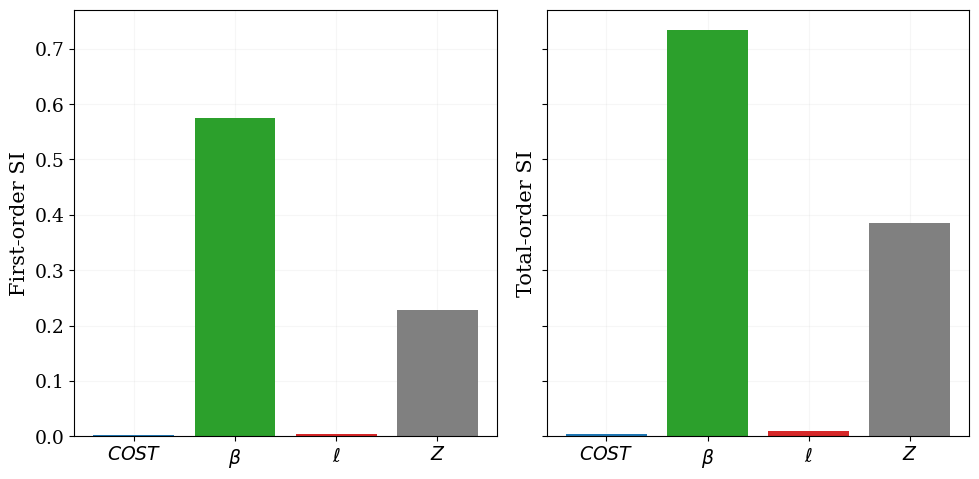

In [105]:
# theta 1 - standarsdised

SPCE_results = np.load(f'optuna_verbose/PT_3_param_st_theta_1_only_N_p3_p5/inter_res_D_Normal_p_4_q_0.75.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, st_theta_1)


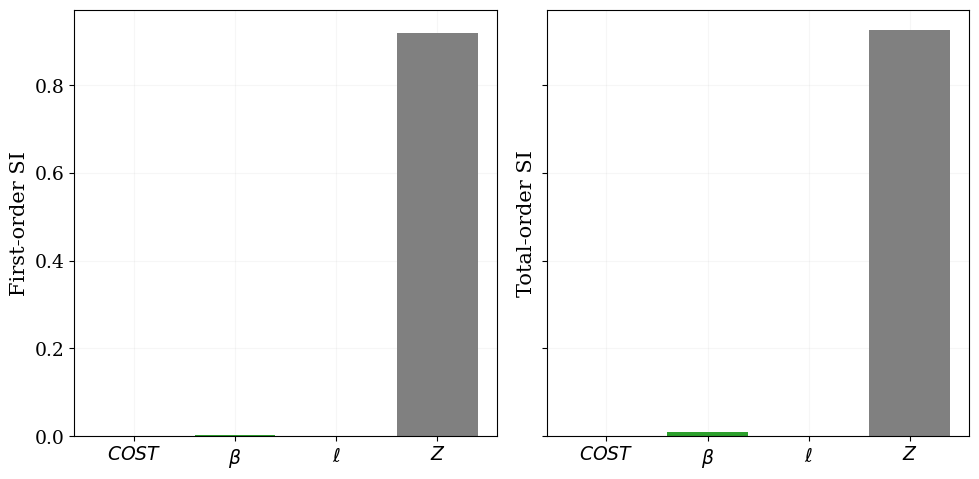

In [106]:
# theta 2 - standarsdised

SPCE_results = np.load(f'optuna_verbose/PT_3_param_st_theta_2_only_N_p5_q075/inter_res_D_Normal_p_5_q_0.75.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, st_theta_2)


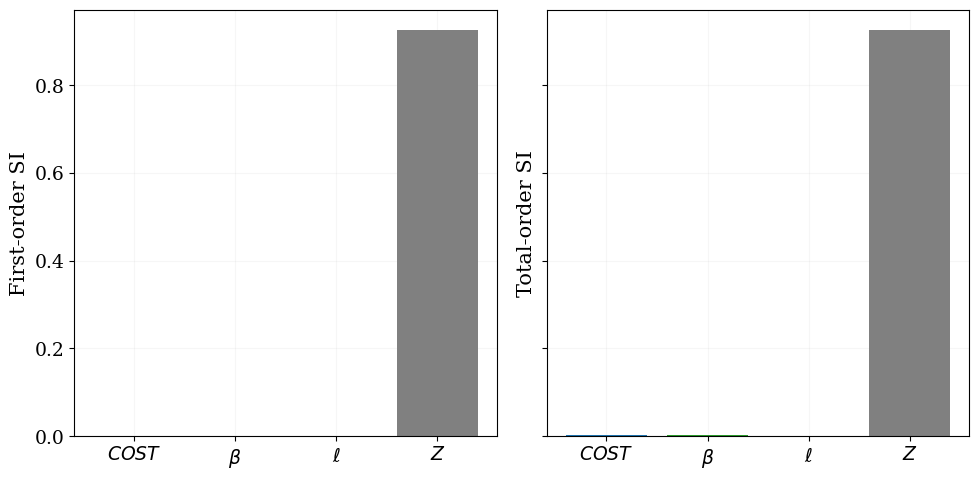

In [107]:
# theta 3 - standarsdised

SPCE_results = np.load(f'optuna_verbose/PT_3_param_st_theta_3_only_N_p3_p5/inter_res_D_Normal_p_5_q_0.5.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, st_theta_3)

## Theta1 with scaling the range for sigma with variance of theta2

`PT_3_param_theta_1_only_N_p3_p5_scaled`

Best from the adaptive algorithm: Normal, p=3, q=1


## Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_theta_2_U_N_p3_p4_scaled`

Uniform:
- p=3, q=0.5: 35499.831384446035
- p=3, q=0.75: 35613.496455853514
- p=3, q=1: 35584.96829645284

- p=4, q=0.5: 35642.376162261
- **p=4, q=0.75: 35643.509359372736**
- p=4, q=1: 35605.587081438425


Normal:
- p=3, q=0.5: 36774.14183582452
- p=3, q=0.75: 36655.76344628612
- p=3, q=1: not run!

- p=4, q=0.5: 36656.13881908594
- **p=4, q=0.75: 36825.43592638198**
- p=4, q=1: 36745.97750319743 


p=5:

`PT_3_param_theta_2_U_N_p5_scaled`

Uniform:
- p=5, q=0.5: 35644.07126028021
- **p=5, q=0.75: 35656.13857093854**
- p=5, q=1: 35598.36221036238

Normal:
- p=5, q=0.5: 36656.128138059925
- **p=5, q=0.75: 36739.50417086715**
- p=5, q=1: 36665.68520178076


Overall best is Normal, p=4, q=0.75

Combine `PT_3_param_theta_2_U_N_p3_p4_scaled` and `PT_3_param_theta_2_U_N_p5_scaled` into `PT_3_param_theta_2_U_N_p3_p5_scaled`


## Theta3 with scaling the range for sigma with variance of theta3


`PT_3_param_theta_3_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 36883.791526766014
- p=3, q=0.75: 36887.85365013998
- p=3, q=1: 37050.266369141835

- p=4, q=0.5: 36899.30089582928
- **p=4, q=0.75: 37051.0089352222**
- p=4, q=1: 36894.95697097131

- p=5, q=0.5: 36889.65365762201
- p=5, q=0.75: 36924.109901540985


`PT_3_param_theta_3_only_N_p_5_q_1_scaled`

- p=5, q=1: 36899.49846828

Overall best is Normal, p=4, q=0.75

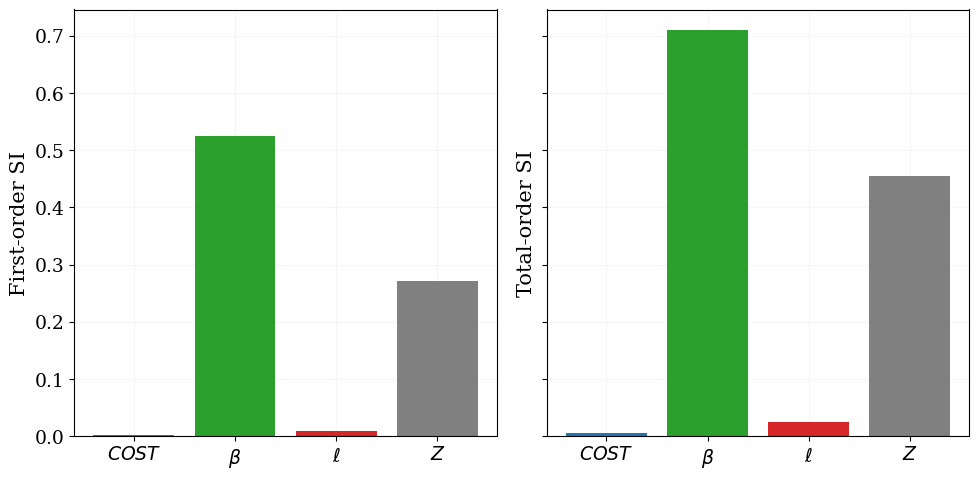

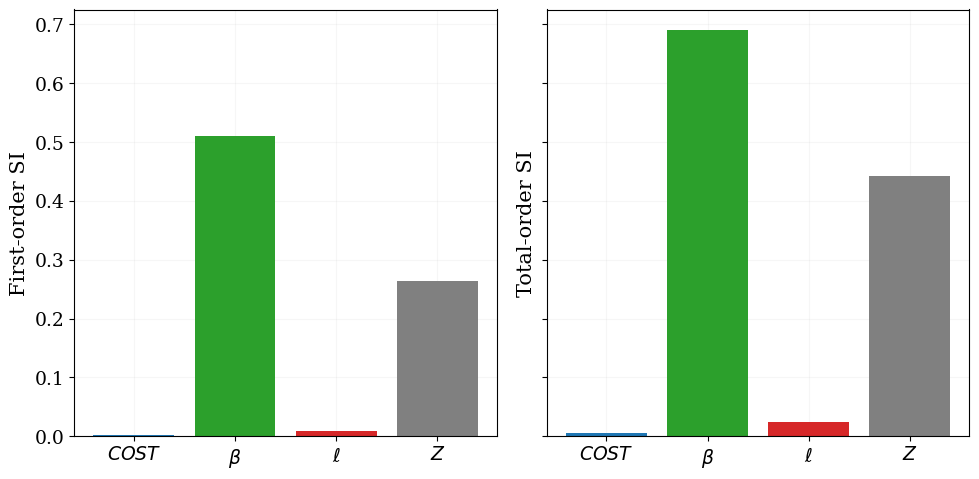

In [128]:
# theta 1 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_theta_1_only_N_p3_p5_scaled/inter_res_D_Normal_p_3_q_1.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, macro_theta_1)

plot_SI_histograms_ns(SPCE_results)

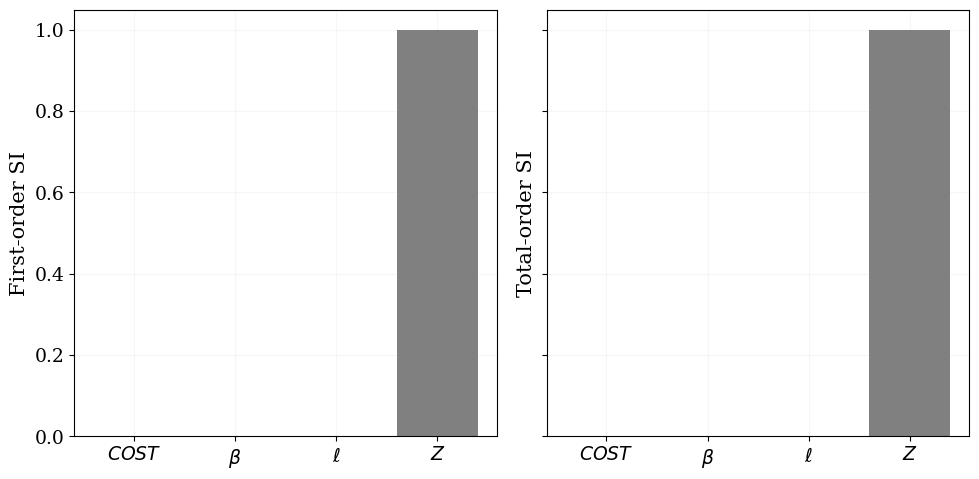

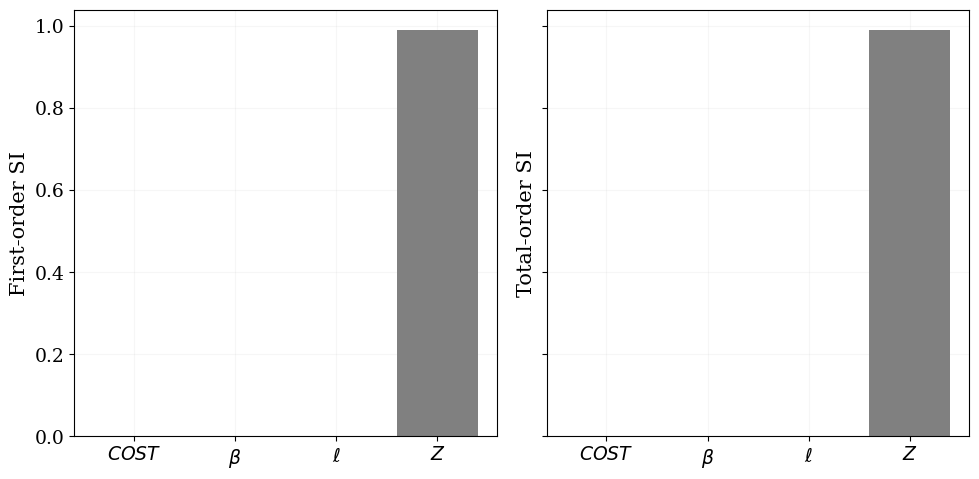

In [127]:
# theta 2 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_theta_2_U_N_p3_p4_scaled/inter_res_D_Normal_p_4_q_0.75.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, macro_theta_2)

plot_SI_histograms_ns(SPCE_results)


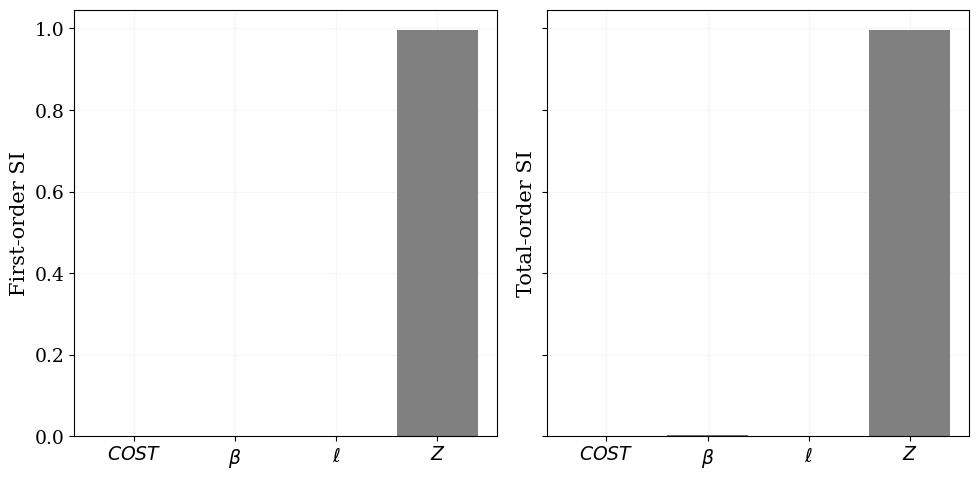

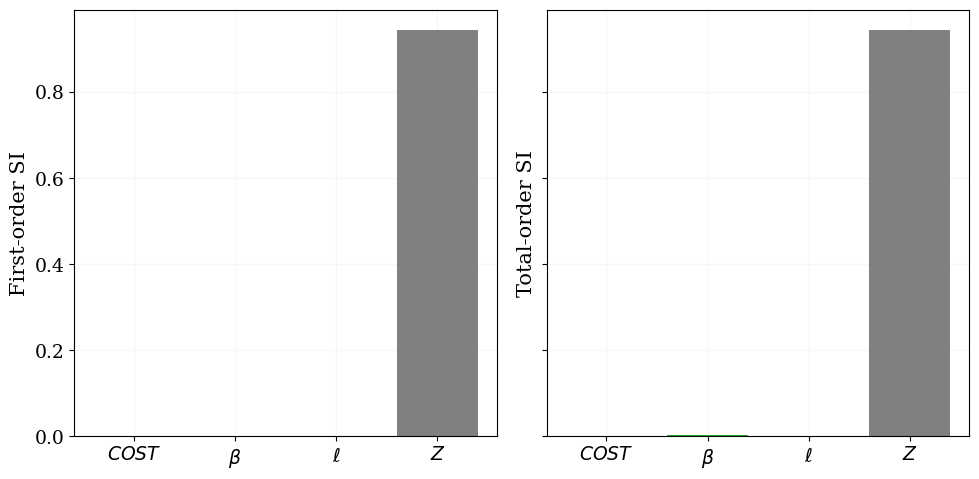

In [129]:
# theta 3 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_theta_3_only_N_p3_p5_scaled/inter_res_D_Normal_p_4_q_0.75.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, macro_theta_3)

plot_SI_histograms_ns(SPCE_results)



# Meso level (only scaled ranges for thetas)

p=35

## Meso-35 Theta1 with scaling the range for sigma with variance of theta1

`PT_3_param_meso_35_theta_1_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 45420.774136789754
- p=3, q=0.75: 45483.78801532663
- p=3, q=1: 45610.55190518743

- p=4, q=0.5: 45482.95952347431
- p=4, q=0.75: 45613.4046526865
- p=4, q=1: 45646.207323488656

- p=5, q=0.5: 45485.51884719992
- p=5, q=0.75: 45646.28658916865
- p=5, q=1: 45645.32985995784

Best overall: Normal, p=5, q=0.75



## Meso-35 Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_meso_35_theta_2_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 48992.62063737991
- p=3, q=0.75: 49015.942158069374
- p=3, q=1: 49057.36653734317

- p=4, q=0.5: 49028.02377475404
- p=4, q=0.75: 49056.61515765713
- p=4, q=1: 49073.79525020444

- p=5, q=0.5: 49017.78625722631
- p=5, q=0.75: 49080.529536009955
- p=5, q=1: 49077.29045475638

Best overall: Normal, p=5, q=0.75



## Meso-35 Theta3 with scaling the range for sigma with variance of theta3

`PT_3_param_meso_35_theta_3_only_N_p3_p5_scaled`

Normal:
- p=3, q=0.5: 48989.62126368984
- p=3, q=0.75: 49083.11498035839
- p=3, q=1: 49043.61866272235

- p=4, q=0.5: 49008.55493780369
- p=4, q=0.75: 49023.63918338075
- p=4, q=1: 49029.30034620184

- p=5: did not run

Best overall: Normal, p=3, q=0.75

In [94]:
result_nonparsim = np.load(f'data/GSA_results/GDMaps/PT_meso_nonparsim_onerun_p_35.npz', 
                               allow_pickle=True)

meso_g_nonparsim = result_nonparsim["x4"]

meso_theta_1 = meso_g_nonparsim[:, 0].reshape(num_samples, 1)
meso_theta_2 = meso_g_nonparsim[:, 1].reshape(num_samples, 1)
meso_theta_3 = meso_g_nonparsim[:, 2].reshape(num_samples, 1)

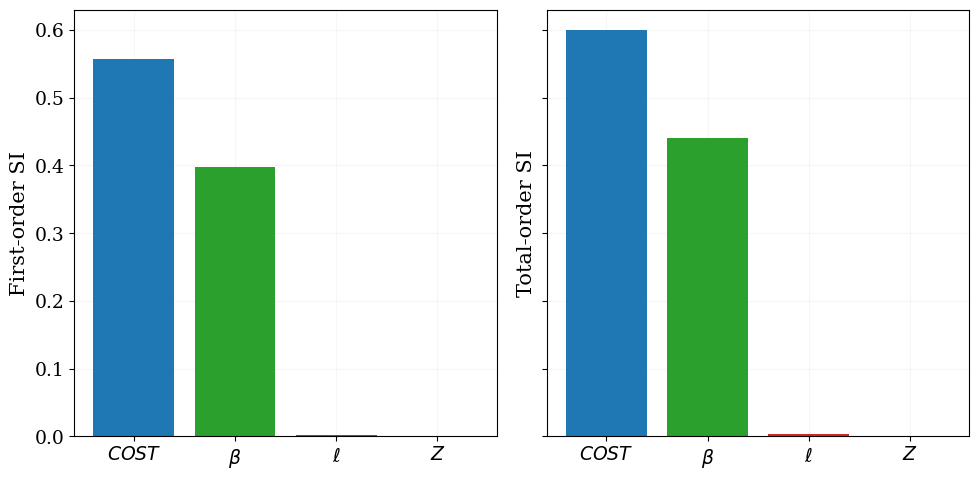

In [130]:
# theta 1 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_meso_35_theta_1_only_N_p3_p5_scaled/inter_res_D_Normal_p_5_q_1.npz', 
                      allow_pickle=True)

# plot_SI_histograms(SPCE_results)
# plot_SI_histograms_ns(SPCE_results)

plot_SI_histograms(SPCE_results, meso_theta_1)


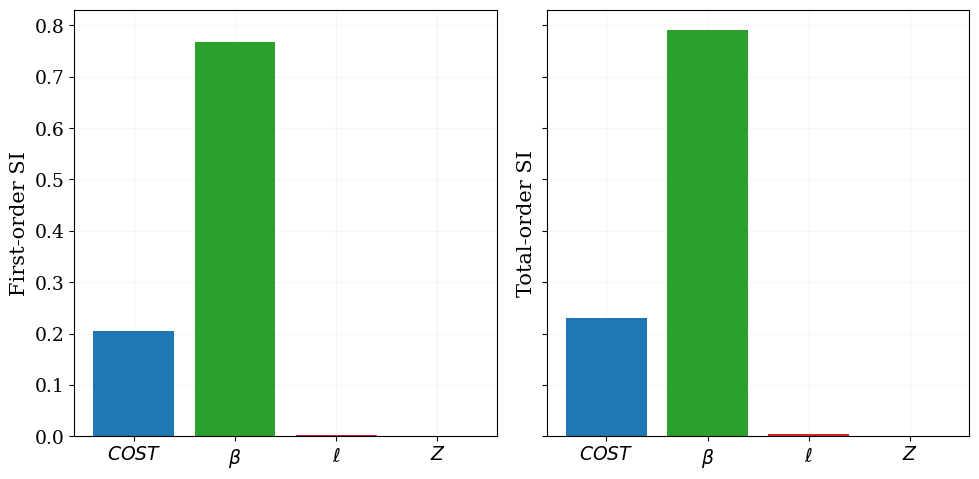

In [131]:
# theta 2 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_meso_35_theta_2_only_N_p3_p5_scaled/inter_res_D_Normal_p_5_q_0.75.npz', 
                      allow_pickle=True)

# plot_SI_histograms_ns(SPCE_results)
plot_SI_histograms(SPCE_results, meso_theta_2)

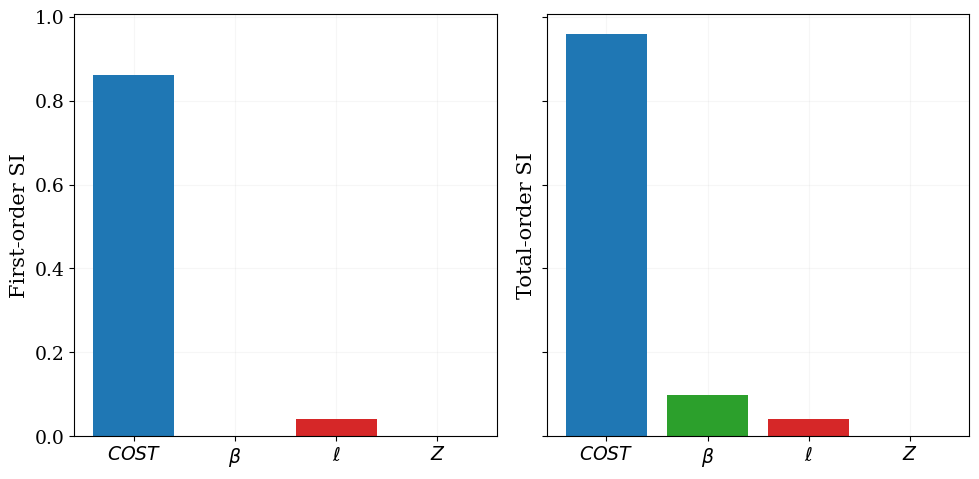

In [133]:
# theta 3 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_meso_35_theta_3_only_N_p3_p5_scaled/inter_res_D_Normal_p_3_q_0.75.npz', 
                      allow_pickle=True)

# plot_SI_histograms_ns(SPCE_results)

plot_SI_histograms(SPCE_results, meso_theta_3)

# Micro level (only scaled ranges for thetas)

p=95

## Micro-95 Theta1 with scaling the range for sigma with variance of theta1

`PT_3_param_micro_95_theta_1_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 38479.69873218128
- p=3, q=0.75: 39354.89424120572

- p=4, q=0.5: 39358.70259561527
- p=4, q=0.75: 39535.88148213489

(p=5 were terminated)


`PT_3_param_micro_95_theta_1_only_N_p5_q_05_q075_scale`

Normal:
- p=5, q=0.5: 39340.97120143965
- p=5, q=0.75: 39413.35914285794


Combine: `PT_3_param_micro_95_theta_1_only_N_p3_p5_q_05_q075_scaled` + `PT_3_param_micro_95_theta_1_only_N_p5_q_05_q075_scale`


`PT_3_param_micro_95_theta_1_only_N_p3_p5_q1_scaled`

Normal:
- *p=3, q=1: 39578.336625918295*
- p=4, q=1: 39503.017527913275
- p=5, q=1: no need? (still running)



## Micro-95 Theta2 with scaling the range for sigma with variance of theta2

`PT_3_param_micro_95_theta_2_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 44587.718402444385
- p=3, q=0.75: 45086.48698855459

- p=4, q=0.5: 45121.10930819564
- p=4, q=0.75: 45153.54591287776

- p=5, q=0.5: 45114.64901779157
- p=5, q=0.75: 45223.72984245453


`PT_3_param_micro_95_theta_2_only_N_p3_p5_q1_scaled`

Normal:
- p=3, q=1: 45150.823635745284
- **p=4, q=1: 45489.305328231676**
- p=5, q=1: 45295.29285612729

Best overall Normal, p=4, q=1



## Micro-95 Theta3 with scaling the range for sigma with variance of theta3

`PT_3_param_micro_95_theta_3_only_N_p3_p5_q_05_q075_scaled`

Normal:
- p=3, q=0.5: 47421.66347048273
- p=3, q=0.75: 47495.84242293473

- p=4, q=0.5: 47534.82134566488
- p=4, q=0.75: 47847.45987775563

- p=5, q=0.5: 47547.52779152598
- p=5, q=0.75: 47877.083762028306


`PT_3_param_micro_95_theta_3_only_N_p3_p5_q1_scaled`

Normal:
- p=3, q=1: 47791.370092558645
- p=4, q=1: 47907.675252396555
- **p=5, q=1: 48018.690637219814**

Best overall: Normal, p=5, q=1

In [100]:
result_nonparsim = np.load(f'data/GSA_results/GDMaps/PT_micro_nonparsim_onerun_p_95.npz', 
                               allow_pickle=True)

micro_g_nonparsim = result_nonparsim["x4"]

micro_theta_1 = micro_g_nonparsim[:, 0].reshape(num_samples, 1)
micro_theta_2 = micro_g_nonparsim[:, 1].reshape(num_samples, 1)
micro_theta_3 = micro_g_nonparsim[:, 2].reshape(num_samples, 1)

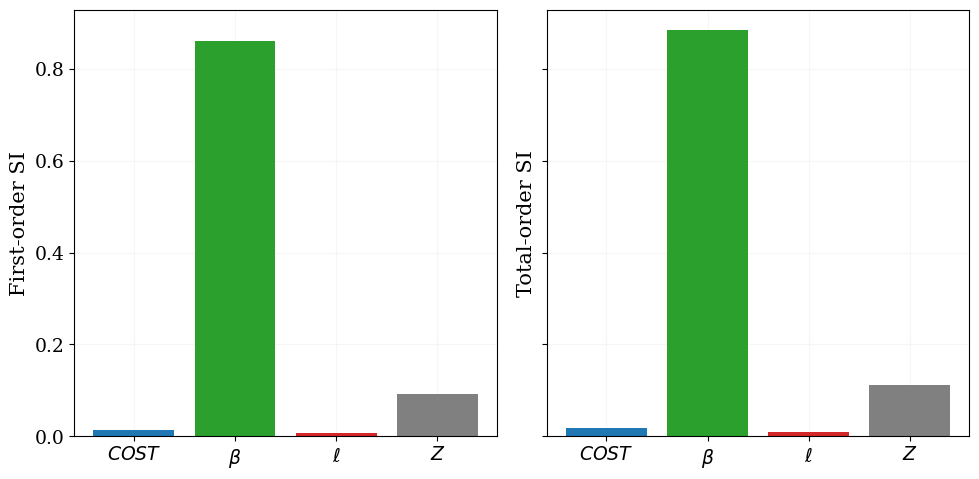

In [114]:
# theta 1 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_micro_95_theta_1_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_3_q_1.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, micro_theta_1)


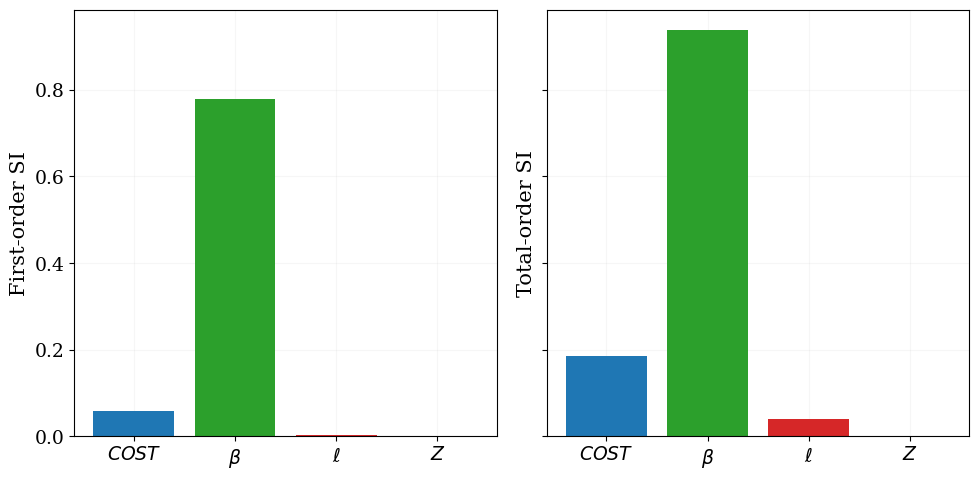

In [115]:
# theta 2 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_micro_95_theta_2_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_5_q_1.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, micro_theta_2)

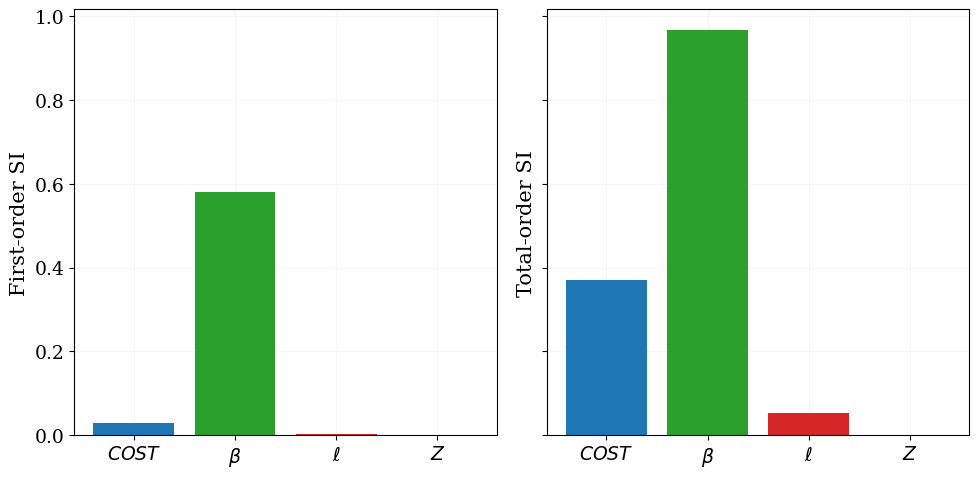

In [116]:
# theta 3 - scaled

SPCE_results = np.load(f'optuna_verbose/PT_3_param_micro_95_theta_3_only_N_p3_p5_q1_scaled/inter_res_D_Normal_p_5_q_1.npz', 
                      allow_pickle=True)

plot_SI_histograms(SPCE_results, micro_theta_3)